In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

from src import classes as c
from src import functions as f
import matplotlib.pyplot as plt
import seaborn as sns

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

## Importing the Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'modeling.csv')
df = pd.read_csv(path, keep_default_na=False)

## Preprocessing and Harness Objects

In [4]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))

sm = SMOTE(random_state=2021)

In [5]:
# creating f1 scorer
f1 = f.f1

In [6]:
modeling = c.Harness(f1)

## Baseline Model KNN

Dropping engineered features to establish the baseline score.

In [7]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [8]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [9]:
baseline_df = f.framer(df, [], excluded)

In [10]:
baseline_df.head(2)

,Target,Subject Age Group,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct
0,1,NA,1984,M,Black,Asian,Male,South
1,0,NA,1965,M,White,NA,NA,NA


In [11]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    46960 non-null  int64 
 1   Subject Age Group         46960 non-null  object
 2   Officer YOB               46960 non-null  int64 
 3   Officer Gender            46960 non-null  object
 4   Officer Race              46960 non-null  object
 5   Subject Perceived Race    46960 non-null  object
 6   Subject Perceived Gender  46960 non-null  object
 7   Precinct                  46960 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.9+ MB


In [12]:
X, y = f.Xy(baseline_df)

In [13]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [14]:
KNN = KNeighborsClassifier()

In [15]:
baseline = make_pipeline(preprocessing, KNN)

In [16]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [17]:
f1_score(baseline.predict(X_train), y_train)

0.4529761082723381

In [18]:
## checking cross validation scores
modeling.report(baseline, X_train, y_train, 'Baseline', 'KNN - Baseline Features')

Baseline has an average F1 of 0.2930510571694175


array([0.29814942, 0.28491425, 0.29144667, 0.30731877, 0.28342618])

## KNN Baseline With SMOTE

In [19]:
baseline_sm = make_sm_pipeline(preprocessing, sm, KNN)

In [20]:
baseline_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [21]:
f1_score(baseline_sm.predict(X_train), y_train)

0.5744202768290491

In [22]:
# checking cross validation scores
modeling.report(baseline_sm, X_train, y_train, 'KNN SMOTE',\
                'Baseline KNN w/ SMOTE')

KNN SMOTE has an average F1 of 0.4185201782434615


array([0.41236183, 0.41164703, 0.43376213, 0.40610061, 0.42872928])

## Logistic Regression

In [23]:
LR = LogisticRegression(max_iter=1000)

In [24]:
lr_smote = make_sm_pipeline(preprocessing, sm, LR)

In [25]:
lr_smote.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [26]:
#scoring the model
f1_score(lr_smote.predict(X_train), y_train)

0.4809787053089529

In [27]:
# checking cross val scores
modeling.report(lr_smote, X_train, y_train, 'LR SMOTE', 'Log Reg w/ SMOTE')

LR SMOTE has an average F1 of 0.4782273316755937


array([0.47928701, 0.47294003, 0.48095002, 0.47984072, 0.47811888])

## Sub-Splitting the Training Data

In [28]:
Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [29]:
lr_smote.fit(Xs_train, ys_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [30]:
f1_score(lr_smote.predict(Xs_train), ys_train)

0.48243213897937026

In [31]:
f1_score(lr_smote.predict(Xs_test), ys_test)

0.4811271975180973

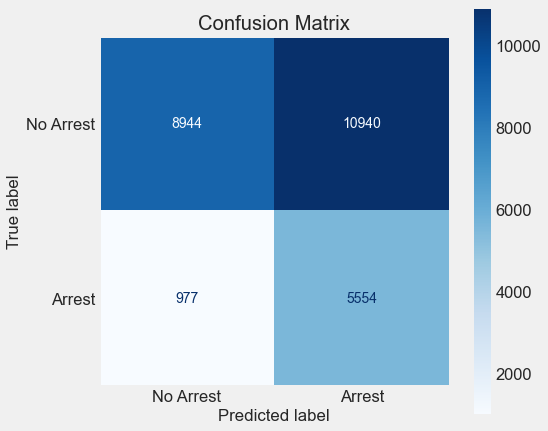

In [32]:
f.confusion(lr_smote, Xs_train, ys_train)

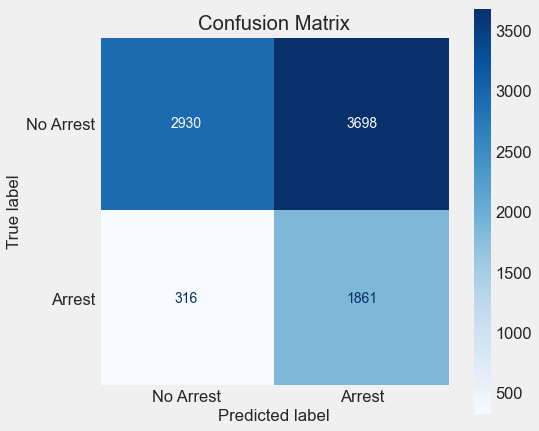

In [33]:
f.confusion(lr_smote, Xs_test, ys_test)

## Investigating the Data More Closely

In [34]:
cols = baseline_df.columns
for col in cols:
    print(f'{df[col].value_counts()}\n')

0    35349
1    11611
Name: Target, dtype: int64

26 - 35         15630
36 - 45          9966
18 - 25          9409
46 - 55          6069
56 and Above     2385
1 - 17           1971
NA               1530
Name: Subject Age Group, dtype: int64

1986    3300
1987    2996
1984    2741
1991    2686
1985    2485
1992    2443
1990    2231
1988    2112
1989    1989
1982    1847
1983    1702
1979    1520
1993    1464
1981    1429
1971    1222
1995    1173
1978    1151
1976    1010
1977    1003
1973     919
1994     913
1980     806
1967     709
1996     656
1968     621
1970     590
1974     553
1969     541
1975     528
1962     453
1964     426
1972     422
1997     415
1965     414
1963     261
1966     224
1958     215
1961     213
1959     173
1960     160
1954      44
1957      43
1900      35
1953      33
1998      23
1955      21
1956      17
1948      11
1952       9
1949       5
1946       2
1951       1
Name: Officer YOB, dtype: int64

M    41558
F     5373
N       29
Name: Officer G

In [35]:
baseline_df['Officer YOB'].describe()

count    46960.000000
mean      1982.972764
std          9.079240
min       1900.000000
25%       1978.000000
50%       1985.000000
75%       1990.000000
max       1998.000000
Name: Officer YOB, dtype: float64

## Creating Age Feature
Creating `Officer Age` feature, dropping invalid ages and `Officer YOB` feature.

In [36]:
df['Officer Age'] = df['Reported Year'] - df['Officer YOB']
df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
df.dropna(subset = ['Officer Age'], inplace=True)

In [37]:
df.drop('Officer YOB', axis=1, inplace=True)

## Testing New Age Feature

In [38]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [39]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [40]:
age_df = f.framer(df, [], excluded)

In [41]:
age_df.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct,Officer Age
0,1,NA,M,Black,Asian,Male,South,31.0
1,0,NA,M,White,NA,NA,NA,50.0


In [42]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46925 entries, 0 to 46959
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    46925 non-null  int64  
 1   Subject Age Group         46925 non-null  object 
 2   Officer Gender            46925 non-null  object 
 3   Officer Race              46925 non-null  object 
 4   Subject Perceived Race    46925 non-null  object 
 5   Subject Perceived Gender  46925 non-null  object 
 6   Precinct                  46925 non-null  object 
 7   Officer Age               46925 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 3.2+ MB


In [43]:
X, y = f.Xy(age_df)

In [44]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [45]:
lr_smote2 = make_sm_pipeline(preprocessing, sm, LR)

In [46]:
lr_smote2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [47]:
#scoring the model
f1_score(lr_smote2.predict(X_train), y_train)

0.48102994245586655

In [48]:
# checking cross val scores
modeling.report(lr_smote2, X_train, y_train, 'LR SMOTE', 'Added Officer Age')

LR SMOTE has an average F1 of 0.47841404674257293


array([0.47879083, 0.47780127, 0.48304113, 0.47769116, 0.47474584])

In [49]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age


In [50]:
df.head(3)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Sector,Beat,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age
0,1,NA,None,7500,M,Black,Asian,Male,NA,NA,...,O,O2,0,2015,10,16,4,11,1,31.0
1,0,NA,None,5670,M,White,NA,NA,NA,NA,...,NA,NA,0,2015,3,19,3,7,0,50.0
2,0,NA,None,4844,M,White,White,Male,NA,NA,...,NA,NA,0,2015,3,21,5,19,0,54.0


## Creating Gender & Racial Affinity Features

In [51]:
df['Racial Affinity'] = [1 if df['Subject Perceived Race'][row]\
                         == df['Officer Race'][row] else 0 for row in df.index]

In [52]:
df['Officer Gender'].value_counts()

M    41552
F     5373
Name: Officer Gender, dtype: int64

In [53]:
df['Officer Gender'] = df['Officer Gender'].apply(lambda x: 'Male' if x=='M' else 'Female')

In [54]:
df['Gender Affinity'] = [1 if df['Subject Perceived Gender'][row]\
                         == df['Officer Gender'][row] else 0 for row in df.index]

In [55]:
df.head(3)

,Target,Subject Age Group,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,...,Weapon Flag,Reported Year,Reported Month,Day of Month,Day of Week,Reported Hour,Beat Flag,Officer Age,Racial Affinity,Gender Affinity
0,1,NA,None,7500,Male,Black,Asian,Male,NA,NA,...,0,2015,10,16,4,11,1,31.0,0,1
1,0,NA,None,5670,Male,White,NA,NA,NA,NA,...,0,2015,3,19,3,7,0,50.0,0,0
2,0,NA,None,4844,Male,White,White,Male,NA,NA,...,0,2015,3,21,5,19,0,54.0,1,1


## Testing New Features

In [56]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [57]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [58]:
df_3 = f.framer(df, [], excluded)

In [59]:
df_3.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct,Officer Age,Racial Affinity,Gender Affinity
0,1,NA,Male,Black,Asian,Male,South,31.0,0,1
1,0,NA,Male,White,NA,NA,NA,50.0,0,0


In [60]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46925 entries, 0 to 46959
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    46925 non-null  int64  
 1   Subject Age Group         46925 non-null  object 
 2   Officer Gender            46925 non-null  object 
 3   Officer Race              46925 non-null  object 
 4   Subject Perceived Race    46925 non-null  object 
 5   Subject Perceived Gender  46925 non-null  object 
 6   Precinct                  46925 non-null  object 
 7   Officer Age               46925 non-null  float64
 8   Racial Affinity           46925 non-null  int64  
 9   Gender Affinity           46925 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 4.9+ MB


In [61]:
X, y = f.Xy(df_3)

In [62]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [63]:
lr_smote3 = make_sm_pipeline(preprocessing, sm, LR)

In [64]:
lr_smote3.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [65]:
#scoring the model
f1_score(lr_smote3.predict(X_train), y_train)

0.4806282042961905

In [66]:
# checking cross val scores
modeling.report(lr_smote3, X_train, y_train, 'LR SMOTE ', 'Log Reg w/ New Age, Race, Gender Features')

LR SMOTE  has an average F1 of 0.47895087789493695


array([0.47853556, 0.47915653, 0.48387625, 0.47711878, 0.47606727])

In [67]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age
4,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"


## Testing Dropping Nulls
Droppin Subject Race Nulls

In [68]:
dropd = df[(df['Subject Perceived Race']!='NA')]

In [69]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [70]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [71]:
df_4 = f.framer(dropd, [], excluded)

In [72]:
X, y = f.Xy(df_4)

In [73]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [74]:
lr_smote4 = make_sm_pipeline(preprocessing, sm, LR)

In [75]:
lr_smote4.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [76]:
#scoring the model
f1_score(lr_smote4.predict(X_train), y_train)

0.48488685973272905

In [77]:
# checking cross val scores
modeling.report(lr_smote4, X_train, y_train, 'LR SMOTE New Age, Race, Gender Features', 'Dropped Subject Race NA')

LR SMOTE New Age, Race, Gender Features has an average F1 of 0.4811326781046031


array([0.48147522, 0.48009329, 0.48106379, 0.48140117, 0.48162993])

In [78]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age
4,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
5,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA


## Dropping Officer Race Nulls

In [79]:
dropd2 = df[(df['Subject Perceived Race']!='NA') &\
           (df['Officer Race']!='NA')]

In [80]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [81]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [82]:
df_5 = f.framer(dropd2, [], excluded)

In [83]:
df_5.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct,Officer Age,Racial Affinity,Gender Affinity
0,1,NA,Male,Black,Asian,Male,South,31.0,0,1
2,0,NA,Male,White,White,Male,NA,54.0,1,1


In [84]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43660 entries, 0 to 46959
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    43660 non-null  int64  
 1   Subject Age Group         43660 non-null  object 
 2   Officer Gender            43660 non-null  object 
 3   Officer Race              43660 non-null  object 
 4   Subject Perceived Race    43660 non-null  object 
 5   Subject Perceived Gender  43660 non-null  object 
 6   Precinct                  43660 non-null  object 
 7   Officer Age               43660 non-null  float64
 8   Racial Affinity           43660 non-null  int64  
 9   Gender Affinity           43660 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 3.7+ MB


In [85]:
X, y = f.Xy(df_5)

In [86]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [87]:
lr_smote5 = make_sm_pipeline(preprocessing, sm, LR)

In [88]:
lr_smote5.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [89]:
#scoring the model
f1_score(lr_smote5.predict(X_train), y_train)

0.48557940801488586

In [90]:
# checking cross val scores
modeling.report(lr_smote5, X_train, y_train, 'LR SMOTE New Age, Race, Gender Features', 'Drpd S Race, O Race NA')

LR SMOTE New Age, Race, Gender Features has an average F1 of 0.481091946995653


array([0.48892734, 0.47634014, 0.48507981, 0.48401668, 0.47109577])

In [91]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age
4,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
6,"LR SMOTE New Age, Race, Gender Features",0.481092,"Drpd S Race, O Race NA"
5,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA


## Dropping Subject Age Nulls

In [92]:
dropd3 = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA')&\
            (df['Subject Age Group']!='NA')]

In [93]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [94]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [95]:
df_6 = f.framer(dropd3, [], excluded)

In [96]:
df_6.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct,Officer Age,Racial Affinity,Gender Affinity
214,0,1 - 17,Male,White,White,Male,NA,27.0,1,1
328,0,36 - 45,Male,White,Asian,Male,NA,37.0,0,1


In [97]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42589 entries, 214 to 46959
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    42589 non-null  int64  
 1   Subject Age Group         42589 non-null  object 
 2   Officer Gender            42589 non-null  object 
 3   Officer Race              42589 non-null  object 
 4   Subject Perceived Race    42589 non-null  object 
 5   Subject Perceived Gender  42589 non-null  object 
 6   Precinct                  42589 non-null  object 
 7   Officer Age               42589 non-null  float64
 8   Racial Affinity           42589 non-null  int64  
 9   Gender Affinity           42589 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 3.6+ MB


In [98]:
X, y = f.Xy(df_6)

In [99]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [100]:
lr_smote6 = make_sm_pipeline(preprocessing, sm, LR)

In [101]:
lr_smote6.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [102]:
#scoring the model
f1_score(lr_smote6.predict(X_train), y_train)

0.4878168152420906

In [103]:
# checking cross val scores
modeling.report(lr_smote6, X_train, y_train, 'LR SMOTE New Age, Race, Gender Features', 'Dpd Nulls S Race, O Race NA, S Age')

LR SMOTE New Age, Race, Gender Features has an average F1 of 0.4842117986791896


array([0.48774423, 0.48220924, 0.48576389, 0.47667485, 0.48866679])

In [104]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age
4,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
5,"LR SMOTE New Age, Race, Gender Features",0.481092,"Drpd S Race, O Race NA"
6,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA
7,"LR SMOTE New Age, Race, Gender Features",0.484212,"Dpd Nulls S Race, O Race NA, S Age"


## Testing on Sub-Splits

In [105]:
Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [106]:
lr_smote6.fit(Xs_train, ys_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [107]:
f1_score(lr_smote6.predict(Xs_train), ys_train)

0.48880754610727856

In [108]:
f1_score(lr_smote6.predict(Xs_test), ys_test)

0.48309859154929585

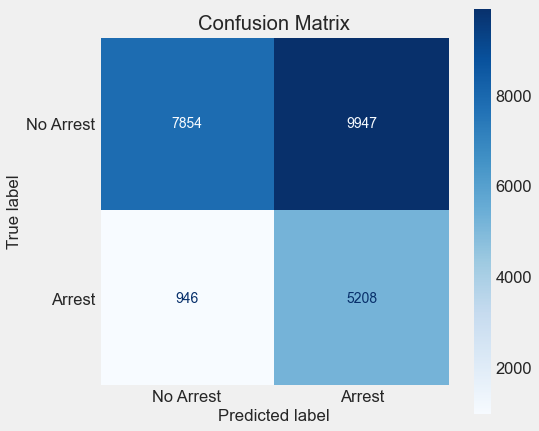

In [109]:
f.confusion(lr_smote6, Xs_train, ys_train)

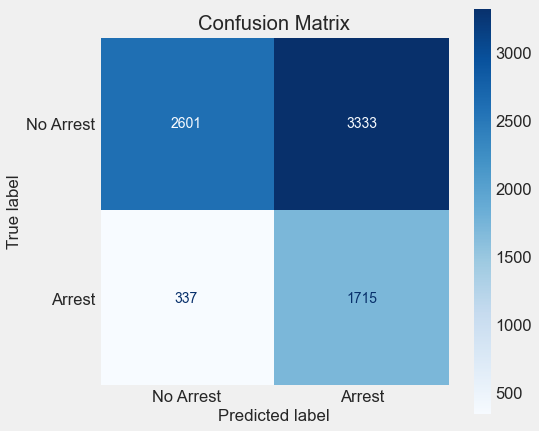

In [110]:
f.confusion(lr_smote6, Xs_test, ys_test)

## Balanced Class Weights

In [111]:
LR_bal = LogisticRegression(class_weight='balanced', max_iter=1000)

In [112]:
lr_smote7 = make_sm_pipeline(preprocessing, sm, LR_bal)

In [113]:
lr_smote7.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [114]:
#scoring the model
f1_score(lr_smote7.predict(X_train), y_train)

0.4878168152420906

In [115]:
# checking cross val scores
modeling.report(lr_smote7, X_train, y_train, 'LR_bal', 'Dpd Nulls S Race, O Race NA, S Age')

LR_bal has an average F1 of 0.4842117986791896


array([0.48774423, 0.48220924, 0.48576389, 0.47667485, 0.48866679])

In [116]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age
4,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
5,"LR SMOTE New Age, Race, Gender Features",0.481092,"Drpd S Race, O Race NA"
6,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA
7,"LR SMOTE New Age, Race, Gender Features",0.484212,"Dpd Nulls S Race, O Race NA, S Age"
8,LR_bal,0.484212,"Dpd Nulls S Race, O Race NA, S Age"


## Checking C Values

## Rough Estimate By Hand

In [117]:
# # preprocessing
# string_selector = make_column_selector(dtype_include='object')
# number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')
# preprocessing = make_column_transformer((OneHotEncoder
#                                          (handle_unknown='ignore'),string_selector),
#                                           (StandardScaler(), number_selector))
# # C = [0.001,.009,0.01,.09,1,5,10,25]
# C = np.logspace(-3, 3, 7)
# for c in C:
#     LR_clf = LogisticRegression(class_weight='balanced', C=c, max_iter=1000)
#     # make_pipeline from imblearn
#     sm = SMOTE(random_state=2021) 
#     pipeline  = make_sm_pipeline(preprocessing, sm, LR_clf)
#     pipeline.fit(X_train, y_train)
#     modeling.report(pipeline, X_train, y_train, 'LR_bal', f'C={c}')
# f1_score(pipeline.predict(X_train), y_train)

In [118]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age
4,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
5,"LR SMOTE New Age, Race, Gender Features",0.481092,"Drpd S Race, O Race NA"
6,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA
7,"LR SMOTE New Age, Race, Gender Features",0.484212,"Dpd Nulls S Race, O Race NA, S Age"
8,LR_bal,0.484212,"Dpd Nulls S Race, O Race NA, S Age"


## Grid Searching Parameters

In [119]:
# LR_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2021)

# pipeline  = make_sm_pipeline(preprocessing, sm, LR_clf)
# pipeline.fit(X_train, y_train)

# C = np.logspace(-3, 3, 7)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga']

# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver }

# grid_clf_f1 = GridSearchCV(pipeline, param_grid = grid_values, scoring = 'f1')
# grid_clf_f1.fit(X_train, y_train)

In [120]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])

In [121]:
LR_tuned = LogisticRegression(class_weight='balanced', C=.01,
                            solver='liblinear', penalty='l1',
                            max_iter=1000, random_state=2021)

pipeline  = make_sm_pipeline(preprocessing, sm, LR_tuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_tuned', 'C=.01, solver=liblinear, penalty=l1')

LR_tuned has an average F1 of 0.4863318684765906


array([0.48685753, 0.48447205, 0.48424163, 0.48632619, 0.48976194])

In [122]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age
4,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
5,"LR SMOTE New Age, Race, Gender Features",0.481092,"Drpd S Race, O Race NA"
6,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA
7,"LR SMOTE New Age, Race, Gender Features",0.484212,"Dpd Nulls S Race, O Race NA, S Age"
8,LR_bal,0.484212,"Dpd Nulls S Race, O Race NA, S Age"
9,LR_tuned,0.486332,"C=.01, solver=liblinear, penalty=l1"


## Testing Tuned Model on Sub-Splits

In [123]:
Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [124]:
pipeline  = make_sm_pipeline(preprocessing, sm, LR_tuned)
pipeline.fit(Xs_train, ys_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('smote', SMOTE(random_state=2021)),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=2021, solver='liblinear'))])

In [125]:
f1_score(pipeline.predict(Xs_train), ys_train)

0.48625811616116704

In [126]:
f1_score(pipeline.predict(Xs_test), ys_test)

0.4835900870730073

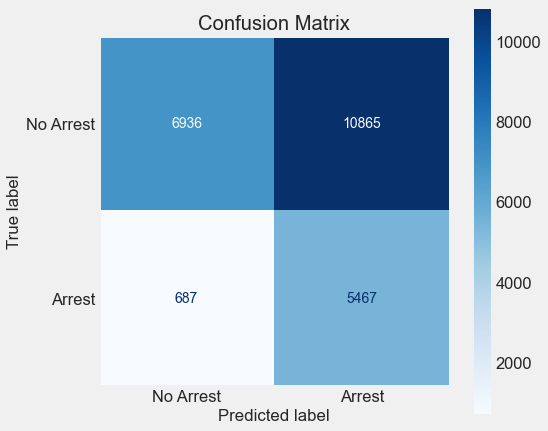

In [127]:
f.confusion(pipeline, Xs_train, ys_train)

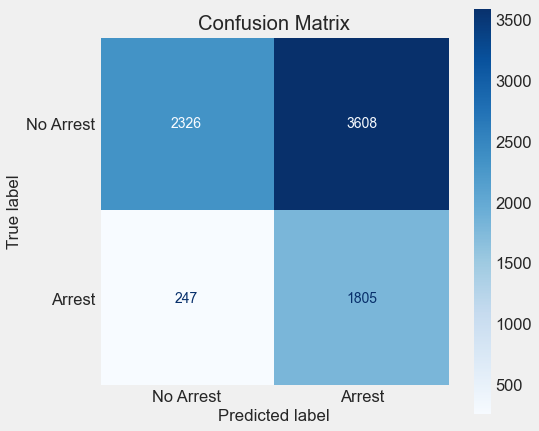

In [128]:
f.confusion(pipeline, Xs_test, ys_test)

## Adding Polynomial Features

In [129]:
preprocessing2 = make_column_transformer((PolynomialFeatures(degree=5, interaction_only=True), number_selector),
                                         (OneHotEncoder(handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))

In [130]:
preprocessing2.fit_transform(X_train);

In [131]:
lr_poly = make_sm_pipeline(preprocessing2, sm, LR_tuned)

In [132]:
lr_poly.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=5,
                                                                     interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
              

In [133]:
f1_score(lr_poly.predict(X_train), y_train)

0.48725616801468086

In [134]:
modeling.report(lr_poly, X_train, y_train, 'LR_tuned Poly', 'LR Polys: d=5, interaction_only=True')

LR_tuned Poly has an average F1 of 0.48643532433321857


array([0.48940533, 0.48635744, 0.48328877, 0.48204607, 0.49107901])

In [135]:
modeling.history

,Name,Accuracy,Notes
0,Baseline,0.293051,KNN - Baseline Features
1,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
2,LR SMOTE,0.478227,Log Reg w/ SMOTE
3,LR SMOTE,0.478414,Added Officer Age
4,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
5,"LR SMOTE New Age, Race, Gender Features",0.481092,"Drpd S Race, O Race NA"
6,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA
7,"LR SMOTE New Age, Race, Gender Features",0.484212,"Dpd Nulls S Race, O Race NA, S Age"
8,LR_bal,0.484212,"Dpd Nulls S Race, O Race NA, S Age"
9,LR_tuned,0.486332,"C=.01, solver=liblinear, penalty=l1"


## Testing Tuned Model on Sub-Splits

In [136]:
Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [137]:
pipeline  = make_sm_pipeline(preprocessing2, sm, LR_tuned)
pipeline.fit(Xs_train, ys_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=5,
                                                                     interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
              

In [138]:
f1_score(pipeline.predict(Xs_train), ys_train)

0.4875338753387534

In [139]:
f1_score(pipeline.predict(Xs_test), ys_test)

0.4824489795918367

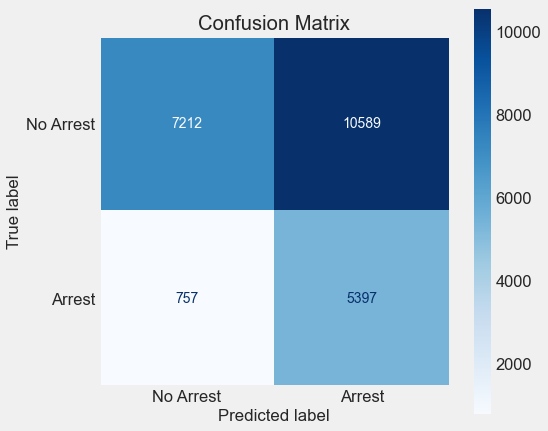

In [140]:
f.confusion(pipeline, Xs_train, ys_train)

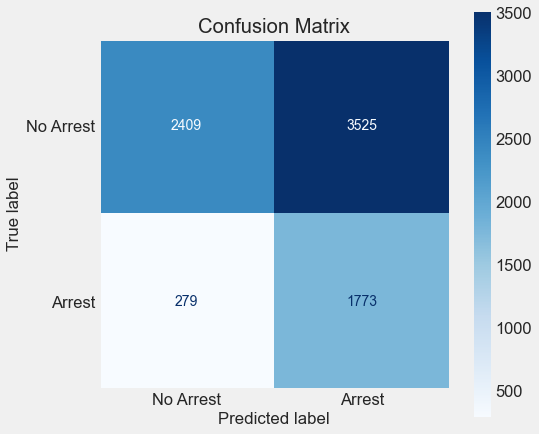

In [141]:
f.confusion(pipeline, Xs_test, ys_test)

## Tuning Polys Model without SMOTE

In [142]:
LR_unbal = LogisticRegression(max_iter=1000, random_state=2021)

pipeline  = make_pipeline(preprocessing2, LR_unbal)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_unbal',
                'polys w/ no smote')

LR_unbal has an average F1 of 0.0


array([0., 0., 0., 0., 0.])

In [143]:
# C = np.logspace(-3, 3, 7)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga']
# weight = [None, 'balanced']

# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver,
#               'logisticregression__class_weight':weight}

# grid_clf_f1 = GridSearchCV(pipeline, param_grid = grid_values, scoring = 'f1')
# grid_clf_f1.fit(X_train, y_train)

In [144]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])
# print('Best class weight:', grid_clf_f1.best_estimator_.get_params()['logisticregression__class_weight'])

In [145]:
LR_utuned = LogisticRegression(max_iter=1000, C=1, penalty='l1',
                               solver='liblinear',
                               class_weight='balanced',
                               random_state=2021)

pipeline  = make_pipeline(preprocessing2, LR_utuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_utuned',
                'tuned w/ no smote')

LR_utuned has an average F1 of 0.4866432358478141


array([0.48885048, 0.48364203, 0.48762165, 0.48121863, 0.4918834 ])

In [146]:
modeling.history

,Name,Accuracy,Notes
0,LR_unbal,0.000000,polys w/ no smote
1,Baseline,0.293051,KNN - Baseline Features
2,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
3,LR SMOTE,0.478227,Log Reg w/ SMOTE
4,LR SMOTE,0.478414,Added Officer Age
5,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
6,"LR SMOTE New Age, Race, Gender Features",0.481092,"Drpd S Race, O Race NA"
7,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA
8,"LR SMOTE New Age, Race, Gender Features",0.484212,"Dpd Nulls S Race, O Race NA, S Age"
9,LR_bal,0.484212,"Dpd Nulls S Race, O Race NA, S Age"


## Tuning no SMOTE, No Polys

In [147]:
LR_unbal = LogisticRegression(max_iter=1000, random_state=2021)

pipeline  = make_pipeline(preprocessing, LR_unbal)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_unbal',
                'no polys, no smote')

LR_unbal has an average F1 of 0.0


array([0., 0., 0., 0., 0.])

In [148]:
# C = np.logspace(-3, 3, 7)
# penalty = ['l1', 'l2']
# solver = ['liblinear', 'saga']
# weight = [None, 'balanced']

# grid_values = {'logisticregression__C':C, 
#                'logisticregression__penalty':penalty,
#                'logisticregression__solver':solver,
#               'logisticregression__class_weight':weight}

# grid_clf_f1 = GridSearchCV(pipeline, param_grid = grid_values, scoring = 'f1')
# grid_clf_f1.fit(X_train, y_train)

In [149]:
# print('Best C:', grid_clf_f1.best_estimator_.get_params()['logisticregression__C'])
# print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['logisticregression__penalty'])
# print('Best solver:', grid_clf_f1.best_estimator_.get_params()['logisticregression__solver'])
# print('Best class weight:', grid_clf_f1.best_estimator_.get_params()['logisticregression__class_weight'])

In [150]:
LR_utuned = LogisticRegression(max_iter=1000, C=.1, penalty='l1',
                               solver='liblinear',
                               class_weight='balanced',
                               random_state=2021)

pipeline  = make_pipeline(preprocessing, LR_utuned)
pipeline.fit(X_train, y_train)
f1_score(pipeline.predict(X_train), y_train)
modeling.report(pipeline, X_train, y_train, 'LR_utuned',
                'tuned no polys, no smote')

LR_utuned has an average F1 of 0.48643390229220174


array([0.48956551, 0.48408739, 0.486158  , 0.48121585, 0.49114276])

In [151]:
modeling.history

,Name,Accuracy,Notes
0,LR_unbal,0.000000,polys w/ no smote
1,LR_unbal,0.000000,"no polys, no smote"
2,Baseline,0.293051,KNN - Baseline Features
3,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
4,LR SMOTE,0.478227,Log Reg w/ SMOTE
5,LR SMOTE,0.478414,Added Officer Age
6,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
7,"LR SMOTE New Age, Race, Gender Features",0.481092,"Drpd S Race, O Race NA"
8,"LR SMOTE New Age, Race, Gender Features",0.481133,Dropped Subject Race NA
9,"LR SMOTE New Age, Race, Gender Features",0.484212,"Dpd Nulls S Race, O Race NA, S Age"


In [152]:
Xs_train, Xs_test, ys_train, ys_test = f.splitter(X_train, y_train)

In [153]:
pipeline  = make_pipeline(preprocessing2, LR_tuned)
pipeline.fit(Xs_train, ys_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=5,
                                                                     interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
              

In [154]:
f1_score(pipeline.predict(Xs_train), ys_train)

0.48603668365790964

In [155]:
f1_score(pipeline.predict(Xs_test), ys_test)

0.48650065530799474

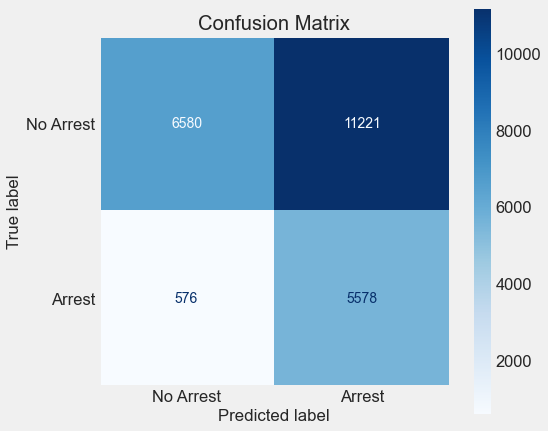

In [156]:
f.confusion(pipeline, Xs_train, ys_train)

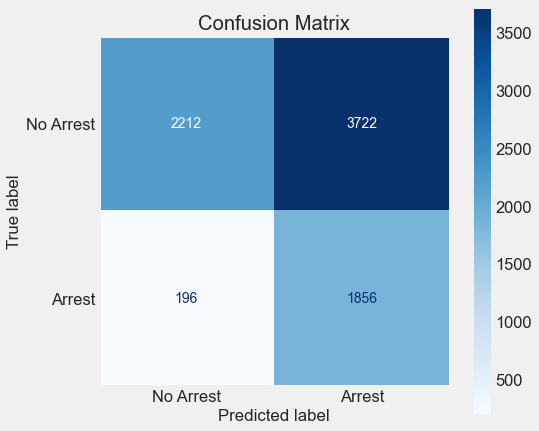

In [157]:
f.confusion(pipeline, Xs_test, ys_test)

## Decision Tree

In [158]:
# features engineered during eda
feature_list3 = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [159]:
excluded3 = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat', 'Weapon Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [160]:
baseline_df2 = f.framer(df, [], excluded3)

In [161]:
baseline_df2.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct,Officer Age,Racial Affinity,Gender Affinity
0,1,NA,Male,Black,Asian,Male,South,31.0,0,1
1,0,NA,Male,White,NA,NA,NA,50.0,0,0


In [162]:
X, y = f.Xy(baseline_df2)

In [163]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [164]:
preprocessing.fit_transform(X_train)

<35193x42 sparse matrix of type '<class 'numpy.float64'>'
	with 316737 stored elements in Compressed Sparse Row format>

In [165]:
DT = DecisionTreeClassifier()

In [166]:
dt_pipeline = make_sm_pipeline(preprocessing2, DT)

In [167]:
modeling.report(dt_pipeline, X_train, y_train, 'Tree CLF', 'Tree w/o SMOTE')

Tree CLF has an average F1 of 0.2864887597198786


array([0.27078891, 0.29264957, 0.28361345, 0.28419936, 0.3011925 ])

## Random Forest

In [168]:
RF = RandomForestClassifier(random_state=2021)

In [169]:
rf_pipeline = make_pipeline(preprocessing, RF)

In [170]:
modeling.report(rf_pipeline, X_train, y_train, 'RandomForest', 'Forest w/o SMOTE')

RandomForest has an average F1 of 0.293585299939841


array([0.28670121, 0.29622132, 0.29989659, 0.28531272, 0.29979466])

In [171]:
rf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'randomforestclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nod

In [172]:
# criterion = ['gini', 'entropy']
# max_depth = [2, 3, None]
# min_samples_split = [2, 5, 10]
# class_weight = ['balanced', 'balanced_subsample']

# grid_values = {'randomforestclassifier__criterion':criterion, 
#                'randomforestclassifier__max_depth':max_depth,
#                'randomforestclassifier__min_samples_split':min_samples_split,
#               'randomforestclassifier__class_weight':class_weight}

# grid_rf_f1 = GridSearchCV(rf_pipeline, param_grid = grid_values, scoring = 'f1')
# grid_rf_f1.fit(X_train, y_train)

In [173]:
# print('Best criterion:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__criterion'])
# print('Best max_depth:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__max_depth'])
# print('Best min_samples_split:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
# print('Best class weight:', grid_rf_f1.best_estimator_.get_params()['randomforestclassifier__class_weight'])

In [174]:
RF = RandomForestClassifier(criterion='gini',
                            max_depth=3, min_samples_split=2,
                            class_weight='balanced',
                            random_state=2021)

In [175]:
rf_pipeline = make_pipeline(preprocessing, RF)

In [176]:
modeling.report(rf_pipeline, X_train, y_train, 'RandomForest', 'Forest w/o SMOTE')

RandomForest has an average F1 of 0.47947849021231403


array([0.47679892, 0.48367313, 0.48026534, 0.47664184, 0.48001321])

In [177]:
modeling.history

,Name,Accuracy,Notes
0,LR_unbal,0.000000,polys w/ no smote
1,LR_unbal,0.000000,"no polys, no smote"
2,Tree CLF,0.286489,Tree w/o SMOTE
3,Baseline,0.293051,KNN - Baseline Features
4,RandomForest,0.293585,Forest w/o SMOTE
5,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
6,LR SMOTE,0.478227,Log Reg w/ SMOTE
7,LR SMOTE,0.478414,Added Officer Age
8,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
17,RandomForest,0.479478,Forest w/o SMOTE


In [180]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        random_state=2021))])

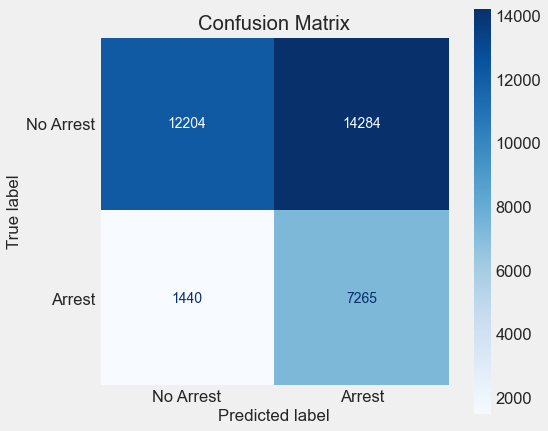

In [181]:
f.confusion(rf_pipeline, X_train, y_train)

## Adding Features
### Weapon Flag

In [182]:
dropd4 = df[(df['Subject Perceived Race']!='NA') &\
            (df['Officer Race']!='NA')&\
            (df['Subject Age Group']!='NA')]

In [183]:
# features engineered during eda
feature_list = ['Weapon Flag', 'Reported Year', 'Reported Month',
                'Day of Month', 'Day of Week', 'Reported Hour', 'Beat Flag']

In [184]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',  'Sector', 'Beat',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [185]:
# including weapon flag
df_7 = f.framer(dropd4, [], excluded)

In [186]:
df_7.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct,Weapon Flag,Officer Age,Racial Affinity,Gender Affinity
214,0,1 - 17,Male,White,White,Male,NA,0,27.0,1,1
328,0,36 - 45,Male,White,Asian,Male,NA,0,37.0,0,1


In [187]:
df_7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42589 entries, 214 to 46959
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    42589 non-null  int64  
 1   Subject Age Group         42589 non-null  object 
 2   Officer Gender            42589 non-null  object 
 3   Officer Race              42589 non-null  object 
 4   Subject Perceived Race    42589 non-null  object 
 5   Subject Perceived Gender  42589 non-null  object 
 6   Precinct                  42589 non-null  object 
 7   Weapon Flag               42589 non-null  int64  
 8   Officer Age               42589 non-null  float64
 9   Racial Affinity           42589 non-null  int64  
 10  Gender Affinity           42589 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 3.9+ MB


In [188]:
X, y = f.Xy(df_7)

In [189]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [190]:
precinct = make_pipeline(preprocessing2, LR_utuned)

In [191]:
precinct.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=5,
                                                                     interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
              

In [192]:
#scoring the model
f1_score(precinct.predict(X_train), y_train)

0.4901048143542369

In [193]:
# checking cross val scores
modeling.report(precinct, X_train, y_train, 'LR+polys, no smote', 'Added Weapon Flag')

LR+polys, no smote has an average F1 of 0.4886063081525423


array([0.49026549, 0.48639032, 0.48563877, 0.48543689, 0.49530007])

In [194]:
modeling.history

,Name,Accuracy,Notes
0,LR_unbal,0.000000,polys w/ no smote
1,LR_unbal,0.000000,"no polys, no smote"
2,Tree CLF,0.286489,Tree w/o SMOTE
3,Baseline,0.293051,KNN - Baseline Features
4,RandomForest,0.293585,Forest w/o SMOTE
5,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
6,LR SMOTE,0.478227,Log Reg w/ SMOTE
7,LR SMOTE,0.478414,Added Officer Age
8,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
9,RandomForest,0.479478,Forest w/o SMOTE


## Sector Flag

In [195]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag', 'Beat',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [196]:
# including weapon flag
df_8 = f.framer(dropd4, [], excluded)

In [197]:
df_8.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct,Sector,Weapon Flag,Officer Age,Racial Affinity,Gender Affinity
214,0,1 - 17,Male,White,White,Male,NA,NA,0,27.0,1,1
328,0,36 - 45,Male,White,Asian,Male,NA,NA,0,37.0,0,1


In [198]:
X, y = f.Xy(df_8)

In [199]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [200]:
sector = make_pipeline(preprocessing2, LR_utuned)

In [201]:
sector.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=5,
                                                                     interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
              

In [202]:
#scoring the model
f1_score(sector.predict(X_train), y_train)

0.49085146232531346

In [203]:
# checking cross val scores
modeling.report(sector, X_train, y_train, 'LR+polys, no smote', 'Added Sector Flag')

LR+polys, no smote has an average F1 of 0.48877256166330857


array([0.48758546, 0.48566308, 0.48754448, 0.48981779, 0.49325199])

In [204]:
modeling.history

,Name,Accuracy,Notes
0,LR_unbal,0.000000,polys w/ no smote
1,LR_unbal,0.000000,"no polys, no smote"
2,Tree CLF,0.286489,Tree w/o SMOTE
3,Baseline,0.293051,KNN - Baseline Features
4,RandomForest,0.293585,Forest w/o SMOTE
5,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
6,LR SMOTE,0.478227,Log Reg w/ SMOTE
7,LR SMOTE,0.478414,Added Officer Age
8,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
9,RandomForest,0.479478,Forest w/o SMOTE


## Beat

In [205]:
excluded = ['Weapon Type', 'Officer ID', 'Initial Call Type', 'Final Call Type',
             'Call Type', 'Officer Squad', 'Arrest Flag',
             'Frisk Flag',
             'Reported Year', 'Reported Month','Day of Month',
             'Day of Week', 'Reported Hour', 'Beat Flag']

In [206]:
# including weapon flag
df_9 = f.framer(dropd4, [], excluded)

In [207]:
df_9.head(2)

,Target,Subject Age Group,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Precinct,Sector,Beat,Weapon Flag,Officer Age,Racial Affinity,Gender Affinity
214,0,1 - 17,Male,White,White,Male,NA,NA,NA,0,27.0,1,1
328,0,36 - 45,Male,White,Asian,Male,NA,NA,NA,0,37.0,0,1


In [208]:
X, y = f.Xy(df_9)

In [209]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

In [210]:
beat = make_pipeline(preprocessing2, LR_utuned)

In [211]:
beat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=5,
                                                                     interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
              

In [212]:
#scoring the model
f1_score(beat.predict(X_train), y_train)

0.49252705098975863

In [213]:
# checking cross val scores
modeling.report(beat, X_train, y_train, 'LR+polys, no smote', 'Added Beat')

LR+polys, no smote has an average F1 of 0.4888316198454178


array([0.48789302, 0.48591423, 0.48875402, 0.48931202, 0.49228481])

In [214]:
modeling.history

,Name,Accuracy,Notes
0,LR_unbal,0.000000,polys w/ no smote
1,LR_unbal,0.000000,"no polys, no smote"
2,Tree CLF,0.286489,Tree w/o SMOTE
3,Baseline,0.293051,KNN - Baseline Features
4,RandomForest,0.293585,Forest w/o SMOTE
5,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
6,LR SMOTE,0.478227,Log Reg w/ SMOTE
7,LR SMOTE,0.478414,Added Officer Age
8,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
9,RandomForest,0.479478,Forest w/o SMOTE


## Testing on SubSplits

In [215]:
Xs_train, Xs_test, ys_train , ys_test = f.splitter(X_train, y_train)

In [216]:
preprocessing2.fit_transform(Xs_train)

<23955x195 sparse matrix of type '<class 'numpy.float64'>'
	with 413348 stored elements in Compressed Sparse Row format>

In [217]:
sub_pipeline = make_pipeline(preprocessing2, LR_utuned)

In [218]:
sub_pipeline.fit(Xs_train, ys_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=5,
                                                                     interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7730>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa5a60c7370>)])),
              

In [219]:
f1_score(sub_pipeline.predict(Xs_train), ys_train)

0.49353780864197533

In [220]:
f1_score(sub_pipeline.predict(Xs_test), ys_test)

0.4843659525188187

In [221]:
modeling.report(sub_pipeline, Xs_train, ys_train, 'LR Polys', 'more features  training')

LR Polys has an average F1 of 0.48857302110636047


array([0.48829431, 0.48626506, 0.48609432, 0.49508747, 0.48712395])

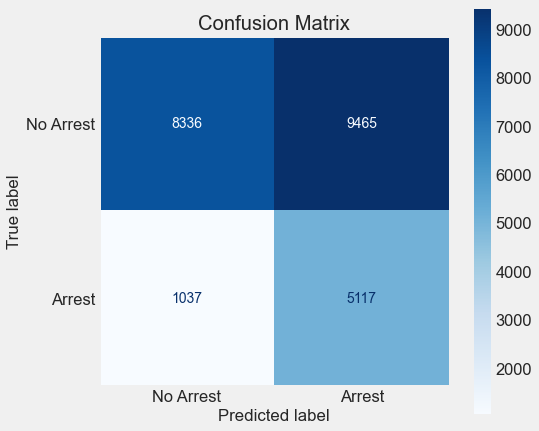

In [222]:
f.confusion(sub_pipeline, Xs_train, ys_train)

In [223]:
modeling.report(sub_pipeline, Xs_test, ys_test, 'LR_Polys', 'More Features testing')

LR_Polys has an average F1 of 0.48801506594159927


array([0.50105263, 0.489301  , 0.47142857, 0.48825623, 0.4900369 ])

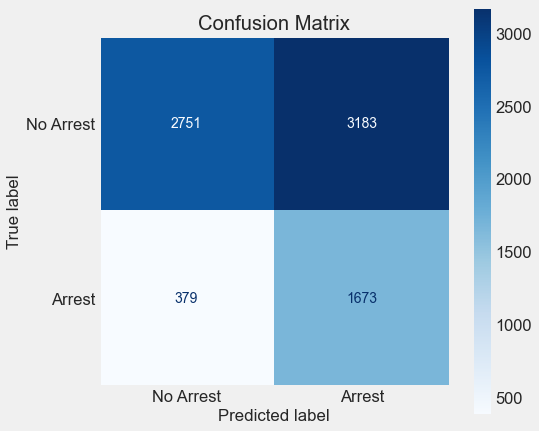

In [224]:
f.confusion(sub_pipeline, Xs_test, ys_test)

In [225]:
modeling.history

,Name,Accuracy,Notes
0,LR_unbal,0.000000,polys w/ no smote
1,LR_unbal,0.000000,"no polys, no smote"
2,Tree CLF,0.286489,Tree w/o SMOTE
3,Baseline,0.293051,KNN - Baseline Features
4,RandomForest,0.293585,Forest w/o SMOTE
5,KNN SMOTE,0.418520,Baseline KNN w/ SMOTE
6,LR SMOTE,0.478227,Log Reg w/ SMOTE
7,LR SMOTE,0.478414,Added Officer Age
8,LR SMOTE,0.478951,"Log Reg w/ New Age, Race, Gender Features"
9,RandomForest,0.479478,Forest w/o SMOTE
